In [1]:
import numpy as np
import scipy.stats
from scipy.stats import norm, uniform
import matplotlib.pyplot as plt
from astropy.stats import histogram as hist
from sklearn.neighbors import KernelDensity
from tqdm.notebook import tqdm

rc = {"font.family" : "serif", 
      "mathtext.fontset" : "cm",
      "font.size" : "12",
      "figure.figsize" : [8,8]}
plt.rcParams.update(rc)

%config InlineBackend.figure_format='retina'

In [2]:
def M_irr(M, spin):
    return M * np.sqrt((1 + np.sqrt(1 - spin**2)) / 2)

In [3]:
def kde_sk(x_grid, data, bandwidth = 1.0, kernel="linear"):
    kde_skl = KernelDensity(bandwidth = bandwidth, 
                            kernel=kernel)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(x_grid[:, np.newaxis]) 

    return np.exp(log_pdf)

In [4]:
def f_pdf(f):
    return 2 * (2*f**2 - 1) / np.sqrt(1 - f**2)

In [5]:
N = int(1e4)
mu, sigma = 1, 0.02
mass_distr = norm(mu, sigma)

spins = uniform.rvs(size = N)
masses = mass_distr.rvs(size = N)

masses_irr = M_irr(masses, spins)

f = masses_irr / masses

In [6]:
#pdf
n, bins = hist(masses_irr, bins='freedman', density=True)
M_hist = scipy.stats.rv_histogram((n, bins))

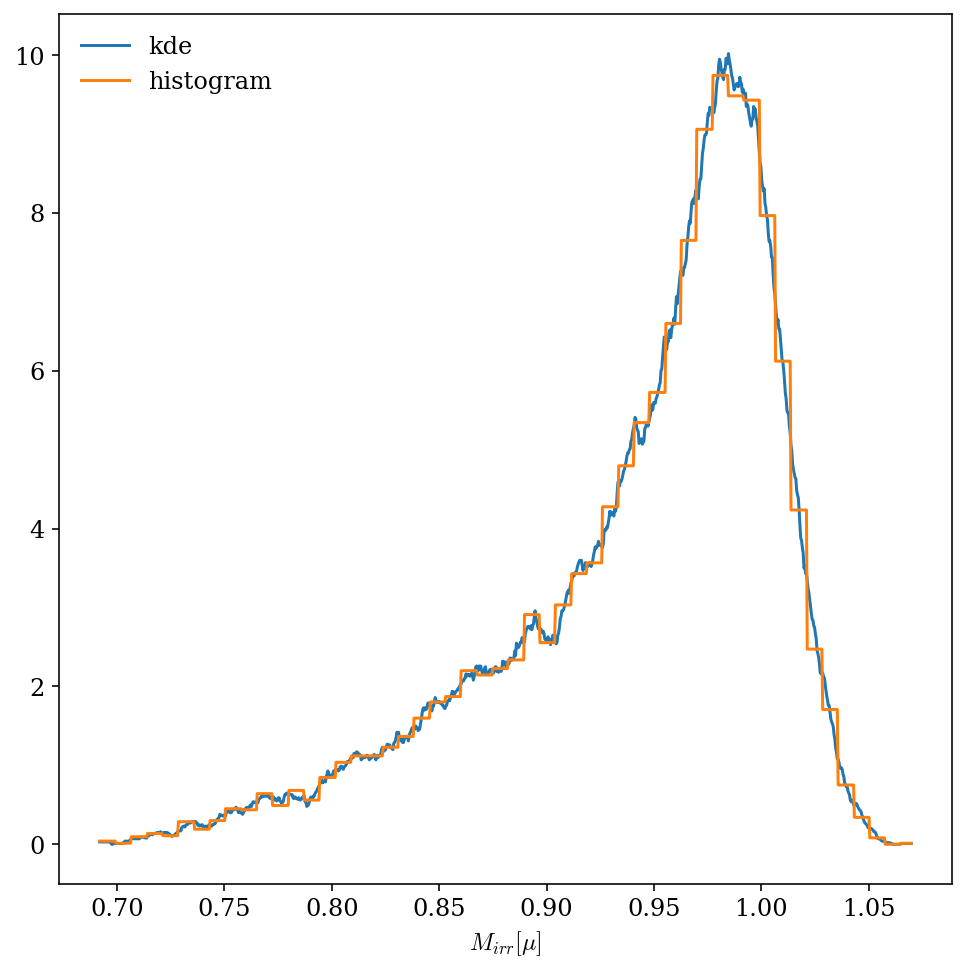

In [7]:
#kde
M_grid = np.linspace(masses_irr.min(), masses_irr.max(), 1000)
kde_th = kde_sk(M_grid, masses_irr, bandwidth = 0.005, kernel="tophat")

plt.plot(M_grid, kde_th, label ='kde')
plt.plot(M_grid, M_hist.pdf(M_grid), label = 'histogram')

plt.legend(frameon = False)
plt.xlabel(r'$M_{irr}[\mu]$')
plt.show()

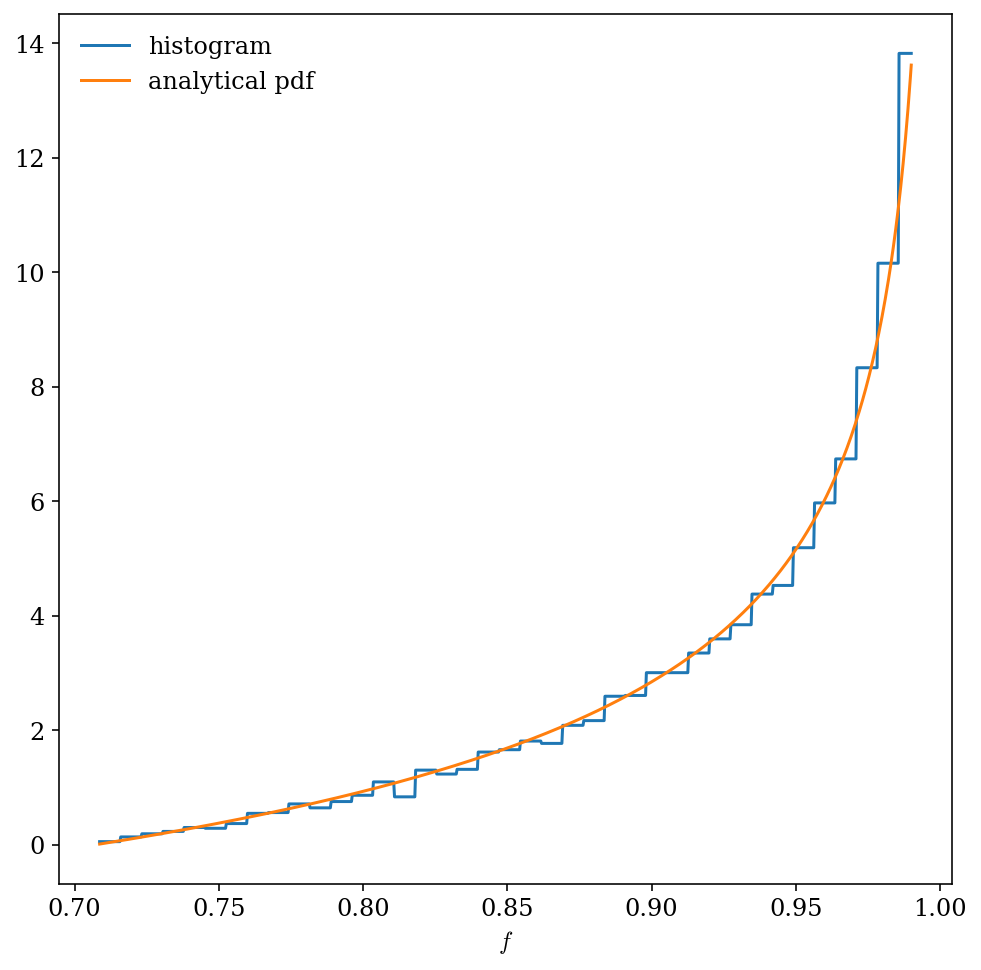

In [14]:
#f hist
f_grid = np.linspace(f.min(), .99, 1000) #clipping the array to 0.99 to prevent the pdf to diverge
n_f, bins_f = hist(f, bins='freedman', density=True)
f_hist = scipy.stats.rv_histogram((n_f, bins_f))

plt.plot(f_grid, f_hist.pdf(f_grid), label = 'histogram')
plt.plot(f_grid, f_pdf(f_grid), label = 'analytical pdf') #analytical result

plt.legend(frameon = False)
plt.xlabel(r'$f$')
plt.show()

the Kolmogorov-Smirnov test for M_irr and f is D_KS = 0.18


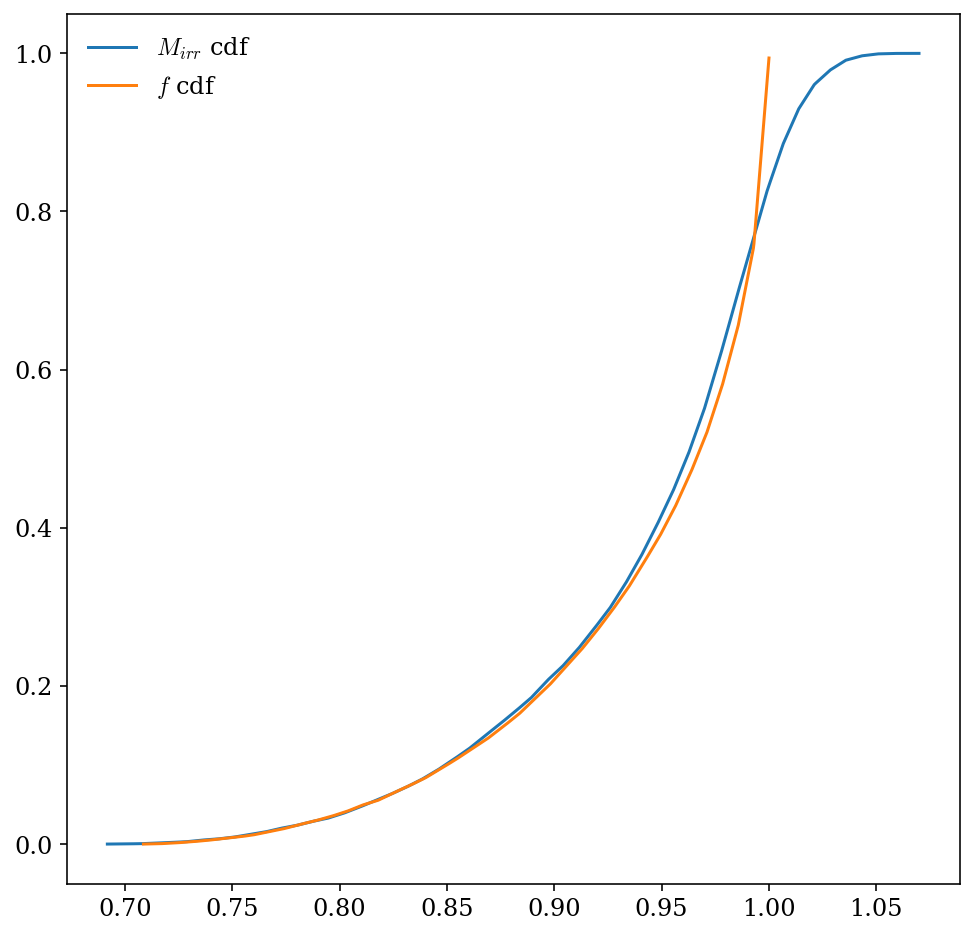

In [17]:
#Sk distance M_irr vs f
f_grid = np.linspace(f.min(), 1, 1000) #now there is no problem with the cdf at f=1
plt.plot(M_grid, M_hist.cdf(M_grid), label = r'$M_{irr}$ cdf')
plt.plot(f_grid, f_hist.cdf(f_grid), label = r'$f$ cdf')

ks_f, p_f = scipy.stats.kstest(masses_irr[masses_irr < 1], f)
print('the Kolmogorov-Smirnov test for M_irr and f is D_KS = %.2f' % ks_f)

plt.legend(frameon = False)
plt.show()

the Kolmogorov-Smirnov test for M_irr and M is D_KS = 0.49


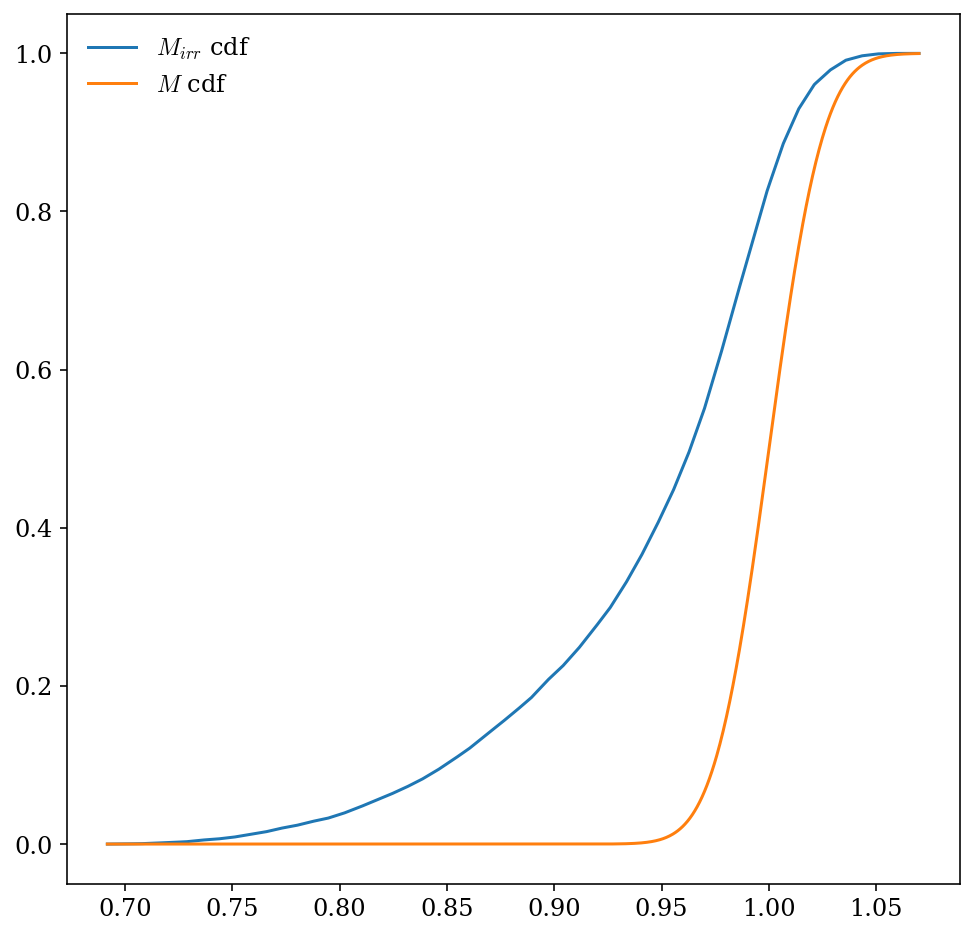

In [16]:
#Sk distance M_irr vs M
plt.plot(M_grid, M_hist.cdf(M_grid), label = r'$M_{irr}$ cdf')
plt.plot(M_grid, mass_distr.cdf(M_grid), label = r'$M$ cdf')

ks_M, p = scipy.stats.kstest(masses_irr, masses)
print('the Kolmogorov-Smirnov test for M_irr and M is D_KS = %.2f' % ks_M)

plt.legend(frameon = False)
plt.show()

## KS test as a function of $\sigma$

In [11]:
sigmas = np.logspace(-3, 3, 100)
    
mass_distr_list = [norm(mu, sigma_try) for sigma_try in sigmas]    
masses_list = [distr_try.rvs(size = N) for distr_try in mass_distr_list]

masses_irr_list = M_irr(masses_list, spins)
f_list = masses_irr_list / masses_list

ks_f_list, p_f_list = np.hsplit(np.array([scipy.stats.kstest(masses_irr_try, f_try) for masses_irr_try, f_try in zip(masses_irr_list, f_list)]),2)
ks_M_list, p_M_list = np.hsplit(np.array([scipy.stats.kstest(masses_irr_try, masses_try) for masses_irr_try, masses_try in zip(masses_irr_list, masses_list)]),2)

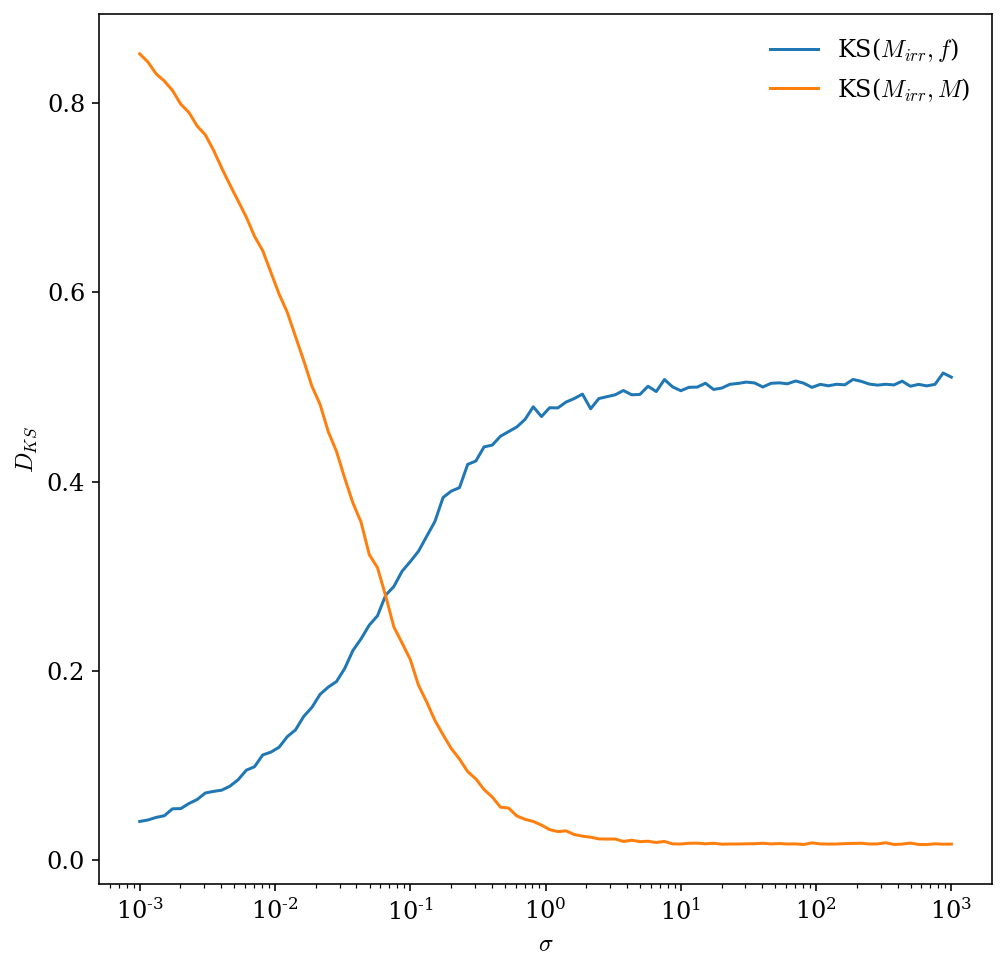

In [18]:
plt.plot(sigmas, ks_f_list, label = r'KS($M_{irr},f$)')
plt.plot(sigmas, ks_M_list, label = r'KS($M_{irr},M$)')

plt.xlabel(r'$\sigma$')
plt.xscale('log')
plt.ylabel(r'$D_{KS}$')
plt.legend(frameon = False)
plt.show()